In [1]:
import pandas as pd
import numpy as np
import google.generativeai as palm
from utils import VectorEmbeddings
import re, ast

from bs4 import BeautifulSoup
from tqdm.auto import tqdm

import psycopg2
from psycopg2.extras import execute_values
from pgvector.psycopg2 import register_vector

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
def remove_html_tags(text:str)->str:
    """Text a string of html text and returns the text without the html tags

    Args:
        text (str): html string you want the tags removed from

    Returns:
        str: text with all html tags removed from it
    """
    clean = re.compile("<.*?>")
    return re.sub(clean, "", text)

In [3]:
def remove_req_qual_str(text:str)->str:
    req_qual_str_to_remove = ['Who May Apply: Only applicants who meet one of the employment authority categories below are eligible to apply for this job.',
    'You will be asked to identify which category or categories you meet, and to provide documents which prove you meet the category or categories you selected. See Proof of Eligibility for an extensive list of document requirements for all employment authorities.',
    '30 Percent or More Disabled Veterans',
    'Current Department of Army Civilian Employees',
    'Current Permanent Department of Defense (DOD) Civilian Employee (non-Army)',
    'Domestic Defense Industrial Base/Major Range and Test Facilities Base Civilian Personnel Workforce',
    'Interagency Career Transition Assistance Plan',
    'Land Management Workforce Flexibility Act',
    'Non-Department of Defense (DoD) Transfer',
    'Office of Personnel Management (OPM) Interchange Agreement Eligible',
    'Priority Placement Program, DoD Military Spouse Preference (MSP) Eligible',
    'ReinstatementVeterans Employment Opportunity Act (VEOA) of 1998',
    'In order to qualify, you must meet the education and/or experience requirements described below.',
    'Experience refers to paid and unpaid experience, including volunteer work done through National Service programs (e.g., Peace Corps, AmeriCorps) and other organizations (e.g., professional; philanthropic; religious; spiritual; community; student; social). You will receive credit for all qualifying experience, including volunteer experience. Your resume must clearly describe your relevant experience; if qualifying based on education, your transcripts will be required as part of your application. ',
    'In order to qualify, you must meet the experience requirements described below.',
    'Additional information about transcripts is in this document.',
    '30 Percent or More Disabled Veterans',
    'Current Department of Army Civilian Employees',
    'Current Permanent Department of Defense (DOD) Civilian Employee (non-Army)',
    'Executive Order (E.O.) 12721',
    'Interagency Career Transition Assistance Plan',
    'Military Spouses, under Executive Order (E.O.) 13473',
    'Non-Appropriated Fund Instrumentality (NAFI)',
    'Non-Department of Defense (DoD) Transfer',
    'Priority Placement Program (PPP), Program S (Military Spouse) registrant',
    'Reinstatement',
    'Veterans Employment Opportunity Act (VEOA) of 1998',
    'Domestic Defense Industrial Base/Major Range and Test Facilities Base Civilian Personnel Workforce',
    'Land Management Workforce Flexibility Act',
    'Office of Personnel Management (OPM) Interchange Agreement Eligible',
    'Priority Placement Program, DoD Military Spouse Preference (MSP) Eligible',
    'Current Department of Army Civilian Employees Applying to OCONUS Positions',
    'Family Member Preference (FMP) for Overseas Employment',
    'Military Spouse Preference (MSP) for Overseas Employment',
    'Current Department of Defense (DOD) Civilian Employee (non-Army)',
    'People with Disabilities, Schedule A',
    'Interagency Career Transition Assistance Plan (ICTAP) Eligible',
    'All U.S. Citizens and Nationals with allegiance to the United States',
    'Veterans and Preference Eligible under Veterans Employment Opportunity Act (VEOA) of 1998',
    'Current Civilian Employees of the Organization',
    'Current Army Defense Civilian Intelligence Personnel System (DCIPS) Employee',
    'Current DoD Defense Civilian Intelligence Personnel System (DCIPS) Employee (non-Army)',
    'Defense Civilian Intelligence Personnel System (DCIPS) Interchange Agreement',
    'Excepted Service Overseas Family Member Appointment',
    'Land Management Workforce Flexibility Act Eligible',
    '10-Point Other Veterans? Rating',
    "5-Point Veterans' Preference",
    'Disabled Veteran w/ a Service-Connected Disability, More than 10%, Less than 30%',
    'Prior Federal Service Employee',
    'United States Citizen Applying to a DCIPS Position',
    'Current Defense Contract Management Agency Employee (DCMA)',
    'Veterans Recruitment Appointment (VRA)',
    'Proposal Evaluation (Contracting by Negotiation)',
    'External Recruitment Military Spouse Preference',
    'Current Defense Contract Management Agency (DCMA) Employee',
    'Who May Apply: US Citizen']

    for string in req_qual_str_to_remove:
        text = text.replace(string,'')

    return text

In [22]:
def job_categories_to_string(value:str)->str:
    """Transforms the job categories to just the actual occupational series

    Args:
        value (str): The value from the 'job_categories'

    Returns:
        str: string that it returns with the OSCs in one comma separated string

    Examples:
        >>> job_categories_to_string("[{'series': '0808'}, {'series': '0810'}]")
        '0808, 0810'
    """
    series_list = ast.literal_eval(value)
    series_values = [item['series'] for item in series_list]
    try:
        return ", ".join(series_values)
    except:
        return None

In [5]:
with open('../.api_key', 'r') as file:
    api_key = file.readline()
vector_embeddings = VectorEmbeddings(api_key=api_key)

In [6]:
df = pd.read_json('job_descriptions.json', lines=True)

In [7]:
df.head()

,usajobs_control_number,position_open_date,position_close_date,summary,hiring_path_explanation,duties,major_duties_list,requirements_conditions_of_employment,requirements_qualifications,requirements_education,...,position_opening_status,applications_started,hiring_paths,job_categories,position_locations,mission_critical_occupations,key_standard_requirements,_links,address,uic
0,514962300,2018-10-29T00:00:00,2018-11-05T00:00:00,<b>About the Position: </b>You will serve as a...,"See ""Who May Apply"" in the ""Qualifications"" se...",None,"In this position, you will provide logistical ...",Appointment may be subject to a suitability or...,<strong>Who May Apply</strong>: Only applicant...,<strong>Some federal jobs allow you to substit...,...,Applications under review,30,"[{'hiringPath': ''}, {'hiringPath': ''}, {'hir...",[{'series': '0346'}],"[{'positionLocationId': 13654878, 'positionLoc...",[],"[{'keyStandardRequirement': None, 'keyStandard...","[{'rel': 'AnnouncementText', 'href': '/api/his...",[GL-APF-W6KAAA USACE LOGISTICS ACTIVITY DO NOT...,W6KAAA
1,514177900,2018-10-18T00:00:00,2018-10-18T00:00:00,<strong>About the Position:</strong><br />\nSe...,None,None,Provide support to professional engineers in p...,Appointment may be subject to a suitability or...,<strong>Who May Apply: US Citizens</strong><br...,There is no positive education requirement for...,...,Applications under review,10,"[{'hiringPath': 'U.S. Citizens, Nationals or t...",[{'series': '0856'}],"[{'positionLocationId': 13602596, 'positionLoc...",[],"[{'keyStandardRequirement': None, 'keyStandard...","[{'rel': 'AnnouncementText', 'href': '/api/his...",[AG-APF-W4G8AA US ARMY COMM & ELCTRS RDEC DO N...,W4G8AA
2,540927700,2019-07-29T00:00:00,2019-08-07T00:00:00,<b>About the Position: </b>The Medical Supply ...,"See ""Who May Apply"" in the ""Qualifications"" se...",None,"Provides operating rooms, wards, clinics and o...",Appointment may be subject to a suitability or...,<p><strong>Who May Apply: </strong>Only applic...,<strong>FOREIGN EDUCATION: </strong>If you are...,...,Applications under review,55,"[{'hiringPath': ''}, {'hiringPath': ''}, {'hir...",[{'series': '0622'}],"[{'positionLocationId': 14553278, 'positionLoc...",[],"[{'keyStandardRequirement': None, 'keyStandard...","[{'rel': 'AnnouncementText', 'href': '/api/his...",[FR-APF-W2DNAA BAMC - FT SAM HOUSTON DO NOT MA...,W2DNAA
3,534312000,2019-05-22T00:00:00,2019-12-16T00:00:00,<strong>About the Position:</strong> This is a...,This is a Direct Hire Solicitation.,Below are examples of the duties that you will...,None,Appointment may be subject to a suitability or...,<strong>Who May Apply: US Citizens</strong><br...,<strong>FOREIGN EDUCATION:</strong> If you are...,...,Job canceled,21,"[{'hiringPath': 'U.S. Citizens, Nationals or t...","[{'series': '0808'}, {'series': '0810'}, {'ser...","[{'positionLocationId': 14363551, 'positionLoc...",[],"[{'keyStandardRequirement': None, 'keyStandard...","[{'rel': 'AnnouncementText', 'href': '/api/his...","[KC-APF-W07504 US ARMY ENGINEER DISTRICT, ALBU...",W07504
4,546156800,2019-09-18T00:00:00,2019-09-27T00:00:00,See below for important information regarding ...,Agency means current permanent DLA employees. ...,None,This position is being filled at either grade ...,Must be a U.S. citizen | Tour of Duty: Flexib...,To qualify for a Contract Specialist your resu...,<p>Substitution of education may not be used i...,...,Candidate selected,67,"[{'hiringPath': ''}, {'hiringPath': ''}, {'hir...",[{'series': '1102'}],"[{'positionLocationId': 14737943, 'positionLoc...",[],"[{'keyStandardRequirement': None, 'keyStandard...","[{'rel': 'AnnouncementText', 'href': '/api/his...",[DLA Aviation 8000 Jefferson Davis Highway Ric...,None


In [8]:
df.shape

(75914, 66)

In [9]:
df.columns

Index(['usajobs_control_number', 'position_open_date', 'position_close_date',
       'summary', 'hiring_path_explanation', 'duties', 'major_duties_list',
       'requirements_conditions_of_employment', 'requirements_qualifications',
       'requirements_education', 'required_standard_documents',
       'required_documents', 'how_to_apply', 'how_to_apply_next_steps',
       'requirements', 'evaluations', 'benefits_url', 'benefits',
       'other_information', 'appointment_type_override',
       'position_schedule_override', 'exclusive_clarification_text',
       'video_url', 'hiring_agency_code', 'hiring_agency_name',
       'hiring_department_code', 'hiring_department_name', 'agency_level',
       'agency_level_sort', 'appointment_type', 'work_schedule', 'pay_scale',
       'salary_type', 'vendor', 'travel_requirement', 'telework_eligible',
       'service_type', 'security_clearance_required', 'security_clearance',
       'who_may_apply', 'announcement_closing_type_code',
       'annou

In [10]:
df[['usajobs_control_number','requirements_qualifications','major_duties_list']].head()

,usajobs_control_number,requirements_qualifications,major_duties_list
0,514962300,<strong>Who May Apply</strong>: Only applicant...,"In this position, you will provide logistical ..."
1,514177900,<strong>Who May Apply: US Citizens</strong><br...,Provide support to professional engineers in p...
2,540927700,<p><strong>Who May Apply: </strong>Only applic...,"Provides operating rooms, wards, clinics and o..."
3,534312000,<strong>Who May Apply: US Citizens</strong><br...,None
4,546156800,To qualify for a Contract Specialist your resu...,This position is being filled at either grade ...


In [11]:
df['duties'].head()

0                                                 None
1                                                 None
2                                                 None
3    Below are examples of the duties that you will...
4                                                 None
Name: duties, dtype: object

In [12]:
req_qual_df = df[['usajobs_control_number','position_open_date', 'position_close_date','position_expire_date','requirements_qualifications','job_categories','uic']]

In [15]:
li_items = []
for idx, row in req_qual_df.iterrows():
    soup = BeautifulSoup(row['requirements_qualifications'], 'html.parser')
    li_elements = soup.find_all('li')
    for li in li_elements:
        li_items.append(li.get_text())

In [404]:
li_item_count = {}
for item in li_items:
    if item in li_item_count:
        li_item_count[item] += 1
    else:
        li_item_count[item] = 1

In [ ]:
for key, value in li_item_count.items():
    if value>200 and value<=500:
        print(key)

In [13]:
req_qual_df['cleaned_text'] = req_qual_df['requirements_qualifications'].apply(remove_html_tags)

/var/folders/9l/1xgvrcy5545b3kwy8sbpb_7h0000gn/T/ipykernel_17632/3438990536.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  req_qual_df['cleaned_text'] = req_qual_df['requirements_qualifications'].apply(remove_html_tags)


In [14]:
req_qual_df['cleaned_text'] = req_qual_df['cleaned_text'].apply(remove_req_qual_str)

/var/folders/9l/1xgvrcy5545b3kwy8sbpb_7h0000gn/T/ipykernel_17632/2078806903.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  req_qual_df['cleaned_text'] = req_qual_df['cleaned_text'].apply(remove_req_qual_str)


In [23]:
req_qual_df['osc'] = req_qual_df['job_categories'].apply(job_categories_to_string)

/var/folders/9l/1xgvrcy5545b3kwy8sbpb_7h0000gn/T/ipykernel_17632/2942304997.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  req_qual_df['osc'] = req_qual_df['job_categories'].apply(job_categories_to_string)


In [24]:
def chunk_df(df: pd.DataFrame, chunk_size: int = 2000) -> list[pd.DataFrame]:
    """_summary_

    Args:
        df (pd.DataFrame): _description_
        chunk_size (int, optional): _description_. Defaults to 2000.

    Returns:
        list[pd.DataFrame]: _description_
    """
    chunks = [df[i:i + chunk_size] for i in range(0, len(df), chunk_size)]
    return chunks

In [25]:
chunks = chunk_df(req_qual_df)

In [38]:
tqdm.pandas()

In [47]:
pg_user = 'bryan'
pg_password = 'bryan_rocks'
pg_host = 'localhost'
pg_db = 'vectors'
connection_string = 'postgresql://{}:{}@{}/{}'.format(pg_user,pg_password,pg_host,pg_db)
table_name = 'requirements_qualifications'
conn = psycopg2.connect(connection_string)
cur = conn.cursor()


In [48]:
drop_statement = 'drop table {}'.format(table_name)

In [49]:
cur.execute(drop_statement)
conn.commit()

In [50]:
table_name = 'requirements_qualifications'
create_statement = """CREATE TABLE {} (
    usajobs_control_number VARCHAR(50), 
    position_open_date timestamp,
    position_close_date timestamp,
    position_expire_date timestamp,
    uic varchar(15), 
    osc varchar(150),
    requirements_qualifications TEXT, 
    embeddings vector(768))""".format(table_name)

In [51]:
cur.execute(create_statement)
conn.commit()

In [70]:
count = 1
for chunk in chunks[3:4]:

    chunk['embeddings'] = chunk['cleaned_text'].progress_apply(vector_embeddings.embed_fn)
    chunk = chunk[['usajobs_control_number', 'position_open_date','position_close_date','position_expire_date','uic', 'osc','cleaned_text', 'embeddings']]

    data_list = [(row['usajobs_control_number'], row['position_open_date'], row['position_close_date'], row['position_expire_date'], row['uic'], row['osc'], row['cleaned_text'], np.array(row['embeddings'])) for index, row in chunk.iterrows()]

    # Added the loop to account for not having text for all jobs.
    for value in data_list:
        conn = psycopg2.connect(connection_string)
        cur = conn.cursor()
        try:
            execute_values(cur, f"INSERT INTO {table_name} (usajobs_control_number, position_open_date,position_close_date,position_expire_date,uic, osc,requirements_qualifications, embeddings) VALUES %s", [value])
            conn.commit()
        except:
            print('failed to insert {}'.format(value[0]))
        # Commit after we insert all embeddings

        conn.close()
        cur.close()

    print('Inserted chunk {}'.format(count))

    count+=1

  0%|          | 0/2000 [00:00<?, ?it/s]

In [63]:
for value in data_list:
    conn = psycopg2.connect(connection_string)
    cur = conn.cursor()
    try:
        execute_values(cur, f"INSERT INTO {table_name} (usajobs_control_number, position_open_date,position_close_date,position_expire_date,uic, osc,requirements_qualifications, embeddings) VALUES %s", [value])
        conn.commit()
    except:
        print('failed to insert {}'.format(value[0]))
    # Commit after we insert all embeddings

    conn.close()
    cur.close()

failed to insert 475604600


In [62]:
data_list[1][0]

735780300

In [69]:
req_qual_df[req_qual_df['usajobs_control_number']==475604600]['requirements_qualifications'].values

array(['<span style="font-size:10.0pt;font-family:" arial",sans-serif;times="" new="" roman""=""><br></span>'],
      dtype=object)

In [64]:
np.array(chunk[chunk['embeddings'].isna()])

array([[475604600, '2017-07-31T00:00:00', '2017-08-14T00:00:00',
        '2017-08-01T00:00:00', None, '2210', '', None]], dtype=object)

In [53]:
done_chunk = chunk.copy()

In [103]:
req_qual_df = req_qual_df[['usajobs_control_number', 'position_open_date','position_close_date','position_expire_date','uic', 'osc','cleaned_text', 'embeddings']]

## Store data in postgres

In [39]:
pg_user = 'bryan'
pg_password = 'bryan_rocks'
pg_host = 'localhost'
pg_db = 'vectors'
connection_string = 'postgresql://{}:{}@{}/{}'.format(pg_user,pg_password,pg_host,pg_db)

In [122]:
conn = psycopg2.connect(connection_string)

In [98]:
cur = conn.cursor()

In [87]:
table_name = 'requirements_qualifications'

In [97]:
create_statement = """CREATE TABLE {table_name} (
    usajobs_control_number VARCHAR(50), 
    position_open_date timestamp,
    position_close_date timestamp,
    position_expire_date timestamp,
    uic varchar(15), 
    osc varchar(50),
    requirements_qualifications TEXT, 
    embeddings vector(768))""".format(table_name = table_name)

In [99]:
cur.execute(create_statement)
conn.commit()

In [114]:
cur = conn.cursor()

In [125]:
register_vector(conn)
cur = conn.cursor()

In [127]:
data_list = [(row['usajobs_control_number'], row['position_open_date'], row['position_close_date'], row['position_expire_date'], row['uic'], row['osc'], row['cleaned_text'], np.array(row['embeddings'])) for index, row in req_qual_df.iterrows()]

# data_list =  [tuple(x) for x in req_qual_df.to_records(index=False)]

# Use execute_values to perform batch insertion
execute_values(cur, f"INSERT INTO {table_name} (usajobs_control_number, position_open_date,position_close_date,position_expire_date,uic, osc,requirements_qualifications, embedding) VALUES %s", data_list)

# Commit after we insert all embeddings
conn.commit()

## Clustering of requirment_qualifications

There are group standards for occupational series codes:  https://www.opm.gov/policy-data-oversight/classification-qualifications/general-schedule-qualification-standards/#url=Group-Standards

These are different groups from the occupational series, i.e., 0800 – Engineering and Architecture Group:  https://www.opm.gov/policy-data-oversight/classification-qualifications/classifying-general-schedule-positions/#url=Standards

Categories:

* Clerical and Administrative Support Positions - `admin_pos`
* Technical and Medical Support Positions - `tech_med_pos`
* Administrative and Management Positions - `admin_man_pos`
* Professional and Scientific Positions - `sci_pos`
* Competitive Service Student Trainee Positions - `student_pos`

In [307]:
admin_pos =['029','072','086','134','203','302','303','304','305','309','312','318','319','322','326','332','335','344','350','351','356','357','359','361','382','390','392','394','503','525','530','540','544','545','561','592','593','675','679','962','963','986','998','1001','1046','1087','1101','1102','1105','1106','1107','1152','1410','1411','1421','1531','1603','1702','1802','2005','2091','2102','2131','2135','2151', '1412']
tech_med_pos = ['019','021','090','102','119','181','186','189','404','421','455','458','459','462','621','622','625','636','640','642','645','646','647','648','649','651','661','681','683','698','704','802','809','817','856','895','1021','1202','1311','1316','1341','1371','1374','1521','1541','1862','1981','2144']
admin_man_pos = ['006','011','017','018','023','028','030','062','080','089','105','106','107','132','136','142','160','188','201','244','260','301','334','306','308','340','341','343','346','360','362','391','501','505','526','560','570','669','670','671','672','673','685','828','901','920','930','950','958','965','967','991','993','996','1001','1008','1010','1020','1035','1040','1051','1054','1056','1071','1082','1083','1084','1101','1103','1104','1109','1130','1140','1144','1145','1146','1147','1150','1160','1161','1162','1163','1165','1169','1170','1171','1173','1176','1361','1397','1421','1601','1630','1640','1654','1658','1667','1670','1702','1712','1715','1801','1805','1810','1811','1849','1850','1860','1889','1894','1910','1980','2001','2003','2010','2030','2032','2050','2101','2110','2123','2125','2130','2150','2161', '2210']
sci_pos = ['020','101','110','130','131','140','150','170','180','184','185','190','193','401','403','405','408','410','413','414','415','430','434','435','436','437','440','454','457','460','470','471','480','482','485','486','487','510','511','512','601','630','631','633','635','637','638','639','644','665','690','696','801','803','804','806','807','808','810','819','830','840','850','854','855','858','861','871','880','881','890','892','893','894','896','1015','1221','1223','1224','1226','1301','1306','1310','1313','1315','1320','1321','1330','1340','1350','1360','1370','1372','1373','1380','1382','1384','1386','1420','1510','1515','1520','1529','1530','1550','1701','1710','1720','1725','1730','1740','1750']
student_pos = ['099','199','299','399','499','599','699','799','899','999','1099','1199','1299','1399','1499','1599','1699','1799','1899','1999','2099','2199','2299']

In [314]:
group_map = {'admin_pos': admin_pos,
'tech_med_pos': tech_med_pos,
'admin_man_pos': admin_man_pos,
'sci_pos': sci_pos,
'student_pos': student_pos,
'other':['905','2181','4749']}

In [312]:
def get_osc_group_classification(osc:str):
    if ',' not in osc:
        if osc.startswith('0'):
            osc = osc[1:]
        for key, list_osc in group_map.items():
            if osc in list_osc:
                return key
    running_list = []        
    oscs = osc.split(', ')
    for osc in oscs:
        if osc.startswith('0'):
            osc = osc[1:]
        for key, list_osc in group_map.items():
            if osc in list_osc:
                if key not in running_list:
                    running_list.append(key)
    if len(running_list) == 1:
        return running_list[0]
    else:
        print(oscs)
        return running_list


1102 - contracting no group, This is an individual qualification standard developed by the Office of Federal Procurement Policy under the authority of 41 U.S.C. 433. It does not apply to Department of Defense positions.

2210 - The Information Technology Management Series, GS-2210, has replaced the GS-334, Computer Specialist Series. This standard covers GS-2210 positions and any remaining GS-334 positions.

905 - General attorney, but not group or individual

4749 - 

1410, 1412 - Occupational Series -- 1400 - 1499 - Library and Archives

2181 - Aircraft operations 

In [315]:
req_qual_df['osc_group'] = req_qual_df['osc'].apply(get_osc_group_classification)

In [316]:
req_qual_df['osc_group'].value_counts()

osc_group
admin_man_pos    486
admin_pos        254
sci_pos          223
other             18
tech_med_pos      14
student_pos        5
Name: count, dtype: int64

In [317]:
tsne = TSNE(random_state=0, n_iter=1000)

In [367]:
X = np.array(req_qual_df['embeddings'].to_list(), dtype=np.float32)
X.shape

(1000, 768)

In [368]:
tsne_results = tsne.fit_transform(X)
df_tsne = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
df_tsne['usajobs_control_number'] = req_qual_df['usajobs_control_number']
df_tsne['osc_group'] = req_qual_df['osc_group']
df_tsne

,TSNE1,TSNE2,usajobs_control_number,osc_group
0,9.623277,7.213680,514962300,admin_man_pos
1,19.902487,-25.037449,514177900,tech_med_pos
2,12.439763,14.591143,540927700,tech_med_pos
3,57.925213,11.437846,534312000,sci_pos
4,-38.221607,7.807544,546156800,admin_pos
...,...,...,...,...
995,15.163944,-18.512560,491365300,admin_man_pos
996,-42.477898,-17.352381,496133900,admin_pos
997,-11.439908,31.355564,502076800,admin_pos
998,-34.080803,-27.070333,509459800,admin_pos


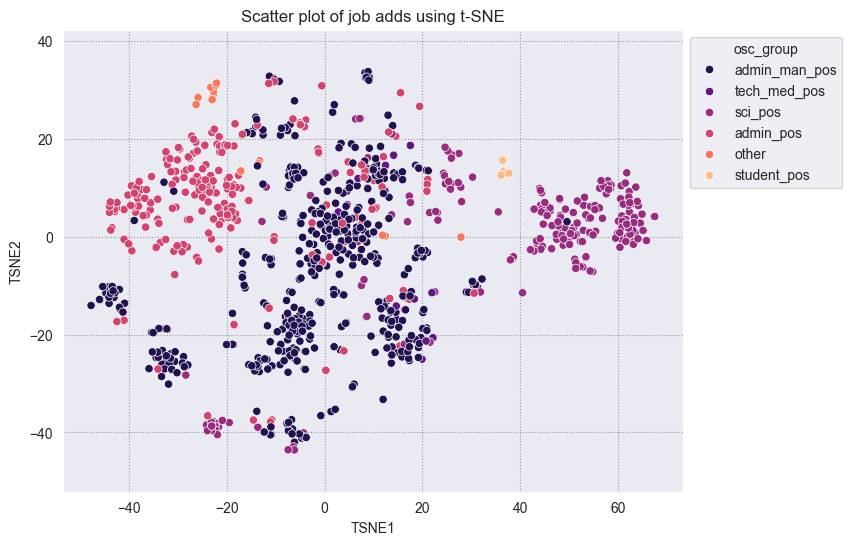

In [369]:
fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='osc_group', palette='magma')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Scatter plot of job adds using t-SNE');
plt.xlabel('TSNE1');
plt.ylabel('TSNE2');
plt.axis('equal')
plt.show()

In [370]:
kmeans_model = KMeans(n_clusters=6, random_state=1, n_init='auto').fit(X)
labels = kmeans_model.fit_predict(X)
df_tsne['cluster'] = labels
df_tsne

,TSNE1,TSNE2,usajobs_control_number,osc_group,cluster
0,9.623277,7.213680,514962300,admin_man_pos,1
1,19.902487,-25.037449,514177900,tech_med_pos,4
2,12.439763,14.591143,540927700,tech_med_pos,1
3,57.925213,11.437846,534312000,sci_pos,2
4,-38.221607,7.807544,546156800,admin_pos,3
...,...,...,...,...,...
995,15.163944,-18.512560,491365300,admin_man_pos,4
996,-42.477898,-17.352381,496133900,admin_pos,0
997,-11.439908,31.355564,502076800,admin_pos,3
998,-34.080803,-27.070333,509459800,admin_pos,5


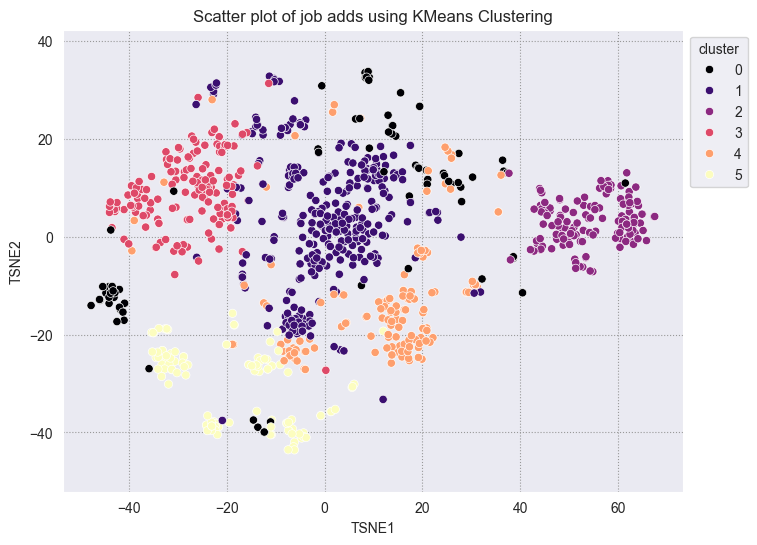

In [371]:
fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='cluster', palette='magma')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Scatter plot of job adds using KMeans Clustering')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.axis('equal')
plt.show()

In [372]:
def get_majority_cluster_per_group(df,column):
  class_clusters = dict()
  clusters = list(df['cluster'].unique())
  for c in clusters:
    # Get rows of dataframe that are equal to c
    rows = df.loc[df['cluster'] == c]
    # Get majority value in Cluster column of the rows selected
    try:
      group = rows[column].mode().values[0]
    except: pass
    # Populate mapping dictionary
    class_clusters[c] = group
  return class_clusters

In [373]:
class_names = ['admin_man_pos',
'multiple',
'sci_pos',
'admin_pos',
'tech_med_pos',
'other']

In [374]:
class_clusters = get_majority_cluster_per_group(df_tsne,'osc_group')

In [375]:
class_clusters

{1: 'admin_man_pos',
 4: 'admin_man_pos',
 2: 'sci_pos',
 3: 'admin_pos',
 0: 'admin_man_pos',
 5: 'admin_man_pos'}

In [376]:
# Convert the Cluster column to use the class name
# class_by_id = {v: k for k, v in class_clusters.items()}

df_tsne['predicted'] = df_tsne['cluster'].map(class_clusters.__getitem__)

# Filter to the correctly matched rows
correct = df_tsne[df_tsne['osc_group'] == df_tsne['predicted']]

# Summarise, as a percentage
correct_counts = correct['osc_group'].value_counts()
true_counts = df_tsne['osc_group'].value_counts()
correct_counts/true_counts


osc_group
admin_man_pos    0.987654
admin_pos        0.685039
other                 NaN
sci_pos          0.650224
student_pos           NaN
tech_med_pos          NaN
Name: count, dtype: float64

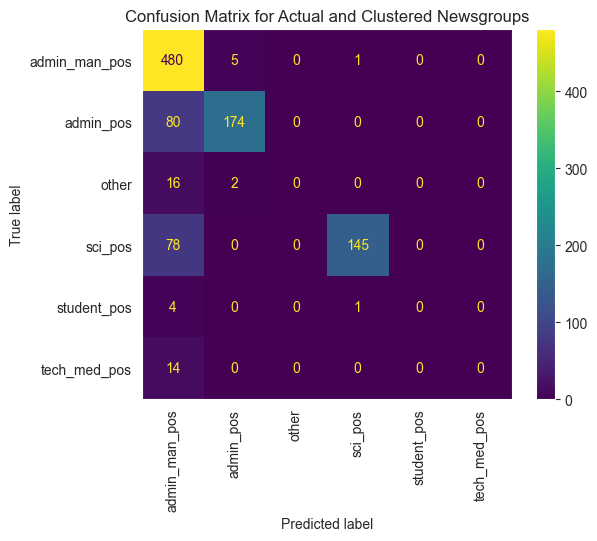

In [377]:
class_names = list(df_tsne['osc_group'].unique())
class_names.sort()

cm = confusion_matrix(df_tsne['osc_group'].to_list(), df_tsne['predicted'].to_list())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation='vertical')
plt.title('Confusion Matrix for Actual and Clustered Newsgroups');
plt.grid(False)

In [343]:
ocs_series_map = {'miscellaneous_occupations': [str(i) for i in np.arange(0,99+1,1)],
'social_science_psychology_and_welfare': [str(i) for i in np.arange(100,199+1,1)],
'human_resources_management': [str(i) for i in np.arange(200,299+1,1)],
'general_administrative_clerical_and_office_services': [str(i) for i in np.arange(300,399+1,1)],
'biological_sciences': [str(i) for i in np.arange(400,499+1,1)],
'accounting_and_budget': [str(i) for i in np.arange(500,599+1,1)],
'medical_hospital_dental_and_public_health': [str(i) for i in np.arange(600,699+1,1)],
'veterinary_medical_science': [str(i) for i in np.arange(700,799+1,1)],
'engineering_and_architecture': [str(i) for i in np.arange(800,899+1,1)],
'legal_and_kindred': [str(i) for i in np.arange(900,999+1,1)],
'information_and_arts': [str(i) for i in np.arange(1000,1099+1,1)],
'business_and_industry': [str(i) for i in np.arange(1100,1199+1,1)],
'copyright_patent_and_trade-mark': [str(i) for i in np.arange(1200,1299+1,1)],
'physical_sciences': [str(i) for i in np.arange(1300,1399+1,1)],
'library_and_archives': [str(i) for i in np.arange(1400,1499+1,1)],
'mathematics_and_statistics': [str(i) for i in np.arange(1500,1599+1,1)],
'equipment_facilities_and_service': [str(i) for i in np.arange(1600,1699+1,1)],
'education': [str(i) for i in np.arange(1700,1799+1,1)],
'inspection_investigation_enforcement_and_compliance': [str(i) for i in np.arange(1800,1899+1,1)],
'quality_assurance_inspection_and_grading': [str(i) for i in np.arange(1900,1999+1,1)],
'supply': [str(i) for i in np.arange(2000,2099+1,1)],
'transportation': [str(i) for i in np.arange(2100,2199+1,1)],
'information_technology_management': [str(i) for i in np.arange(2200,2299+1,1)]}

In [350]:
def get_osc_series_classification(osc:str):
    if ',' not in osc:
        if osc.startswith('0'):
            osc = osc[1:]
        for key, list_osc in ocs_series_map.items():
            if osc in list_osc:
                return key
    running_list = []        
    oscs = osc.split(', ')
    for osc in oscs:
        if osc.startswith('0'):
            osc = osc[1:]
        for key, list_osc in ocs_series_map.items():
            if osc in list_osc:
                if key not in running_list:
                    running_list.append(key)
    if len(running_list) == 1:
        return running_list[0]
    else:
        return 'multiple'

In [351]:
req_qual_df['osc_series'] = req_qual_df['osc'].apply(get_osc_series_classification)

In [352]:
req_qual_df['osc_series'].value_counts()

osc_series
business_and_industry                                  276
general_administrative_clerical_and_office_services    207
engineering_and_architecture                           149
information_technology_management                       95
quality_assurance_inspection_and_grading                57
multiple                                                38
accounting_and_budget                                   35
supply                                                  28
mathematics_and_statistics                              19
legal_and_kindred                                       15
social_science_psychology_and_welfare                   13
library_and_archives                                    12
equipment_facilities_and_service                        10
transportation                                           9
education                                                9
miscellaneous_occupations                                6
human_resources_management                   

In [354]:
tsne_results = tsne.fit_transform(X)
df_tsne = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
df_tsne['usajobs_control_number'] = req_qual_df['usajobs_control_number']
df_tsne['osc_group'] = req_qual_df['osc_group']
df_tsne['osc_series'] = req_qual_df['osc_series']
df_tsne.head()

,TSNE1,TSNE2,usajobs_control_number,osc_group,osc_series
0,9.623277,7.213680,514962300,admin_man_pos,general_administrative_clerical_and_office_ser...
1,19.902487,-25.037449,514177900,tech_med_pos,engineering_and_architecture
2,12.439763,14.591143,540927700,tech_med_pos,medical_hospital_dental_and_public_health
3,57.925213,11.437846,534312000,sci_pos,engineering_and_architecture
4,-38.221607,7.807544,546156800,admin_pos,business_and_industry


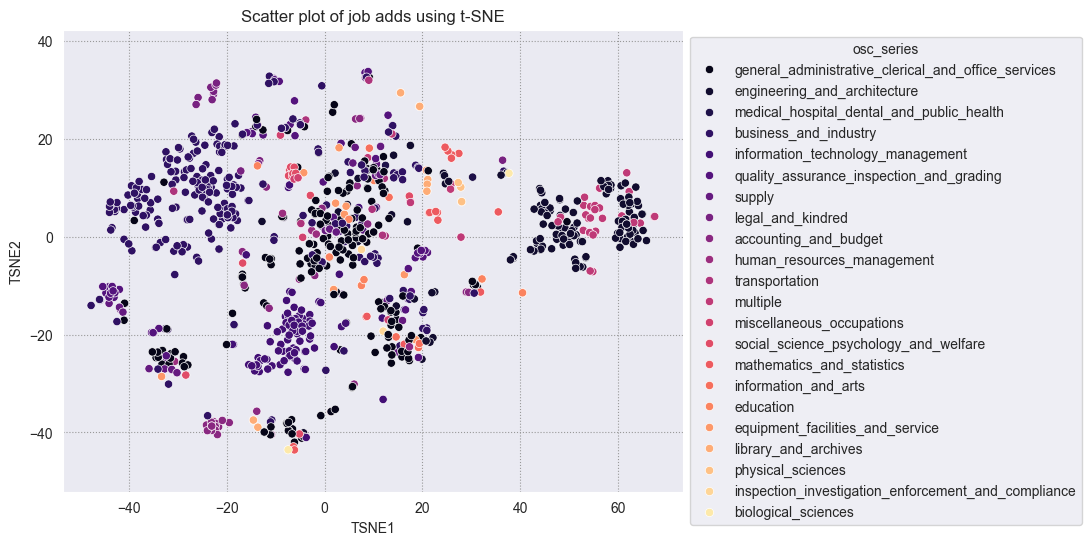

In [355]:
fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='osc_series', palette='magma')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Scatter plot of job adds using t-SNE');
plt.xlabel('TSNE1');
plt.ylabel('TSNE2');
plt.axis('equal')
plt.show()

In [356]:
kmeans_model = KMeans(n_clusters=22, random_state=1, n_init='auto').fit(X)
labels = kmeans_model.fit_predict(X)
df_tsne['cluster'] = labels
df_tsne

,TSNE1,TSNE2,usajobs_control_number,osc_group,osc_series,cluster
0,9.623277,7.213680,514962300,admin_man_pos,general_administrative_clerical_and_office_ser...,9
1,19.902487,-25.037449,514177900,tech_med_pos,engineering_and_architecture,5
2,12.439763,14.591143,540927700,tech_med_pos,medical_hospital_dental_and_public_health,14
3,57.925213,11.437846,534312000,sci_pos,engineering_and_architecture,10
4,-38.221607,7.807544,546156800,admin_pos,business_and_industry,16
...,...,...,...,...,...,...
995,15.163944,-18.512560,491365300,admin_man_pos,general_administrative_clerical_and_office_ser...,5
996,-42.477898,-17.352381,496133900,admin_pos,business_and_industry,0
997,-11.439908,31.355564,502076800,admin_pos,business_and_industry,1
998,-34.080803,-27.070333,509459800,admin_pos,business_and_industry,21


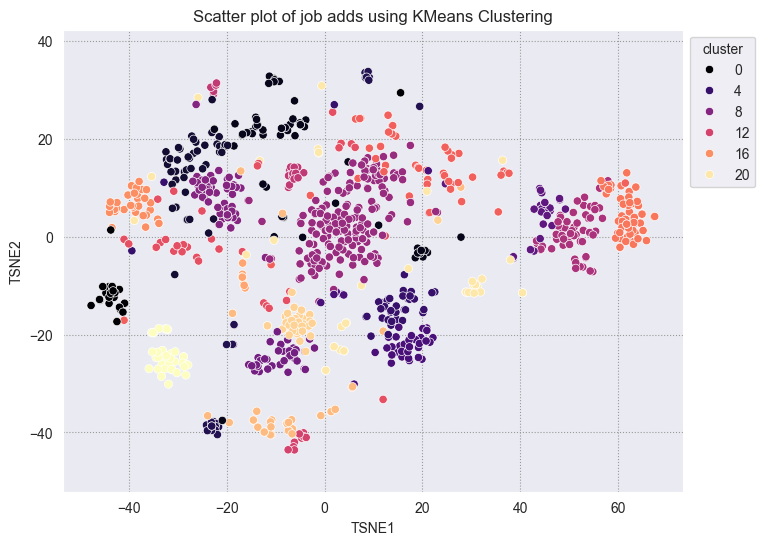

In [357]:
fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='cluster', palette='magma')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Scatter plot of job adds using KMeans Clustering')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.axis('equal')
plt.show()

In [362]:
class_clusters = get_majority_cluster_per_group(df_tsne, 'osc_series')

In [363]:
class_clusters

{9: 'general_administrative_clerical_and_office_services',
 5: 'general_administrative_clerical_and_office_services',
 14: 'mathematics_and_statistics',
 10: 'engineering_and_architecture',
 16: 'business_and_industry',
 19: 'information_technology_management',
 0: 'quality_assurance_inspection_and_grading',
 21: 'general_administrative_clerical_and_office_services',
 8: 'business_and_industry',
 13: 'business_and_industry',
 20: 'business_and_industry',
 4: 'general_administrative_clerical_and_office_services',
 18: 'general_administrative_clerical_and_office_services',
 6: 'engineering_and_architecture',
 1: 'business_and_industry',
 7: 'information_technology_management',
 12: 'general_administrative_clerical_and_office_services',
 15: 'engineering_and_architecture',
 2: 'business_and_industry',
 11: 'social_science_psychology_and_welfare',
 3: 'accounting_and_budget',
 17: 'general_administrative_clerical_and_office_services'}

In [364]:
df_tsne['predicted'] = df_tsne['cluster'].map(class_clusters.__getitem__)

# Filter to the correctly matched rows
correct = df_tsne[df_tsne['osc_series'] == df_tsne['predicted']]

# Summarise, as a percentage
correct_counts = correct['osc_series'].value_counts()
true_counts = df_tsne['osc_series'].value_counts()
correct_counts/true_counts

osc_series
accounting_and_budget                                  0.371429
biological_sciences                                         NaN
business_and_industry                                  0.735507
education                                                   NaN
engineering_and_architecture                           0.791946
equipment_facilities_and_service                            NaN
general_administrative_clerical_and_office_services    0.826087
human_resources_management                                  NaN
information_and_arts                                        NaN
information_technology_management                      0.778947
inspection_investigation_enforcement_and_compliance         NaN
legal_and_kindred                                           NaN
library_and_archives                                        NaN
mathematics_and_statistics                             0.473684
medical_hospital_dental_and_public_health                   NaN
miscellaneous_occupations    

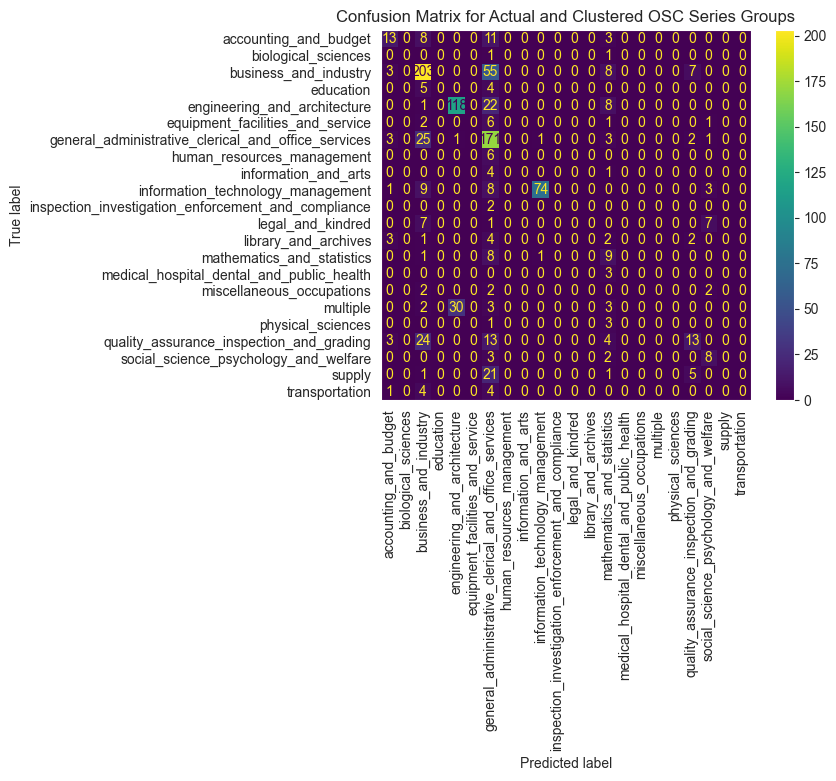

In [365]:
class_names = list(df_tsne['osc_series'].unique())
class_names.sort()

cm = confusion_matrix(df_tsne['osc_series'].to_list(), df_tsne['predicted'].to_list())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation='vertical')
plt.title('Confusion Matrix for Actual and Clustered OSC Series Groups');
plt.grid(False)